In [ ]:
import joblib
import keras
import numpy as np
import time
from pathlib import Path

from romgw.config.env import PROJECT_ROOT
from romgw.maths.ei import empirical_interpolant
from romgw.plotting.core import plot_mismatch
from romgw.typing.utils import validate_literal
from romgw.waveform.base import ComponentWaveform, FullWaveform
from romgw.waveform.dataset import ComponentWaveformDataset, FullWaveformDataset
from romgw.waveform.params import PhysicalParams
from romgw.typing.core import (
    BBHSpinType,
    ModeType,
    ComponentType,
    COMPONENT_VALUES,
    RealArray,
    ComplexArray
)

import matplotlib.pyplot as plt
from matplotlib import gridspec
from romgw.config.env import COMMON_TIME
from romgw.maths.core import mismatch

2025-11-21 11:50:19.267322: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-21 11:50:19.284576: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 11:50:20.036550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 11:50:23.608605: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [ ]:
# mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
def get_ei_bits(ei_dir: str | Path) -> dict:
    """"""
    ei_dir = Path(ei_dir)

    empirical_time_nodes = np.load(ei_dir / "empirical_time_nodes.npy",
                                   allow_pickle=False)
    B_matrix = np.load(ei_dir / "B_matrix.npy", allow_pickle=False)

    return {
        "empirical_time_nodes": empirical_time_nodes,
        "B_matrix": B_matrix,
    }

In [4]:
def get_model_bits(model_dir: str | Path) -> dict:
    """"""
    model_dir = Path(model_dir)
    
    x_scaler = joblib.load(model_dir / "x_scaler.gz")
    y_scaler = joblib.load(model_dir / "y_scaler.gz")
    model = keras.models.load_model(model_dir / "model.keras")

    return {
        "x_scaler": x_scaler,
        "y_scaler": y_scaler,
        "model": model,
    }

In [5]:
def predict(x: RealArray, x_scaler, y_scaler, model) -> RealArray:
    """"""
    x = np.asarray(x)
    x = x[np.newaxis, :]
    x_scaled = x_scaler.transform(x)
    y_pred_raw = model.predict(x_scaled, verbose=0).astype(np.float64)
    y_pred = y_scaler.inverse_transform(y_pred_raw)
    return y_pred

In [6]:
def load_romgw(
    bbh_spin: BBHSpinType,
    mode: ModeType,
    model_name: str = "NonLinearRegression",
):
    """"""
    # Validate literals. Raises error if invalid.
    bbh_spin = validate_literal(bbh_spin, BBHSpinType)
    mode = validate_literal(mode, ModeType)

    data_dir = lambda c: PROJECT_ROOT / "data" / bbh_spin / "train" / mode / c
    ei_dir = lambda c: data_dir(c) / "empirical_interpolation"
    model_dir = lambda c: data_dir(c) / "models" / model_name

    bits = {}
    for component in COMPONENT_VALUES:
        bits[component] = {}
        bits[component]["ei"] = get_ei_bits(ei_dir(component))
        bits[component]["model"] = get_model_bits(model_dir(component))
        
    return bits

In [7]:
def load_raw_test_data(
    bbh_spin: BBHSpinType,
    mode: ModeType,
    component: ComponentType,
) -> tuple[RealArray, RealArray]:
    """"""
    # Validate literals. Raises error if invalid.
    bbh_spin = validate_literal(bbh_spin, BBHSpinType)
    mode = validate_literal(mode, ModeType)
    component = validate_literal(component, ComponentType)

    # Load waveforms.
    wf_dir = PROJECT_ROOT / "data" / bbh_spin / "test" / mode / component / "raw"
    waveforms = ComponentWaveformDataset.from_directory(wf_dir,
                                                        component=component)

    # Load empirical time nodes.
    empirical_time_nodes_file = (
        PROJECT_ROOT / "data" / bbh_spin / "train" / mode / component / "empirical_interpolation" / "empirical_time_nodes.npy"
    )
    empirical_time_nodes = np.load(empirical_time_nodes_file,
                                   allow_pickle=False)

    # Make X and Y data arrays.
    X_raw = waveforms.params_array
    Y_raw = waveforms.array[:, empirical_time_nodes]

    return X_raw, Y_raw

In [8]:
def generate_romgw(
    x: RealArray,
    bits: dict,
) -> FullWaveform:
    """"""
    surrogate_component_waveforms = {}

    for component in COMPONENT_VALUES:
        # ----- Process to time -----
        # Predict values of waveform with params `x` at empirical time nodes.
        predicted_values_at_nodes = predict(x, **bits[component]["model"]).flatten()

        # Empirical interpolant to approximate the full timeseries.
        surrogate_arr = empirical_interpolant(predicted_values_at_nodes,
                                              bits[component]["ei"]["B_matrix"])
        # ----- ------- -- ---- -----
        
        # Construct ComponentWaveform object.
        surrogate_component_waveforms[component] = ComponentWaveform(
            waveform_arr=surrogate_arr,
            params=PhysicalParams(*x),
            component=component
        )
        
    return FullWaveform.from_components(**surrogate_component_waveforms)

In [9]:
bbh_spin = "NS"
mode = "2,2"
model_name = "NonLinearRegression"

In [10]:
red_or_mod = load_romgw(bbh_spin, mode, model_name)

2025-11-21 11:50:27.503277: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
X_test, Y_test_amp = load_raw_test_data(bbh_spin, mode, "amplitude")
_     , Y_test_phi = load_raw_test_data(bbh_spin, mode, "phase")

Waveforms loaded.                                                               
Waveforms loaded.                                                               


In [12]:
waveforms = [] ; i = 0
for params in X_test:
    i += 1
    print(f"Generating waveform {i:0{len(str(len(X_test) - 1))}d}/{len(X_test)}", end='\r')
    waveforms.append(generate_romgw(params, red_or_mod))
romgw_waveforms = FullWaveformDataset(waveforms)

In [13]:
fiducial_wf_dir = PROJECT_ROOT / "data" / bbh_spin / "test" / mode / "full" / "raw"
fiducial_waveforms = FullWaveformDataset.from_directory(fiducial_wf_dir)

Waveforms loaded.                                                               


/home/crc972/projects/RedOrModGW/src/romgw/maths/core.py:2: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [ ]:
# def visualise_mismatch(
#     fiducial_waveforms: FullWaveformDataset,
#     surrogate_waveforms: FullWaveformDataset,
#     n: int | None = None,
#     verbose:bool = False,
#     seed: int | None = None,
# ) -> None:
#     """Compare fiducial waveforms to their surrogate counterparts."""
#     # ----- Handle NoneType n -----
#     n = n if n else len(waveforms)

#     # ----- Pick n 'random' waveforms -----
#     rng = np.random.default_rng(seed)
#     idxs = rng.permutation(len(waveforms))[:n]
#     fiducial_waveforms = FullWaveformDataset([fiducial_waveforms[i]
#                                               for i in idxs])
#     surrogate_waveforms = FullWaveformDataset([surrogate_waveforms[i]
#                                                for i in idxs])
#     if verbose:
#         print(f"{fiducial_waveforms=}")
#         print(f"{surrogate_waveforms=}")

#     # ----- Visualise n waveforms -----
#     fig = plt.figure(figsize=(12, 3*n))
#     spec = gridspec.GridSpec(
#         ncols=1,
#         nrows=n,
#         height_ratios=(*[3 for _ in range(n)],),
#         left=0,
#         right=1,
#         hspace=0.6
#     )

#     axs = []

#     for i in range(n):
#         ax = fig.add_subplot(spec[i])
#         axs.append(ax)
        
#         wf_fid = fiducial_waveforms[i].real
#         wf_sur = surrogate_waveforms[i].real

#         ax.plot(COMMON_TIME, wf_fid, label="fiducial")
#         ax.plot(COMMON_TIME, wf_sur, label="surrogate", linestyle='--')

#         x_text = (xmin := ax.get_xlim()[0]) + 0.05*((xmax := ax.get_xlim()[1]) - xmin)
#         y_text = (ymin := ax.get_ylim()[0]) + 0.05*((ymax := ax.get_ylim()[1]) - ymin)
#         ax.text(x=x_text, y=y_text, s=f"mismatch={mismatch(wf_fid, wf_sur):.6e}")
        
#         ax.set_xlim(-5000, 250)
#         ax.set_xlabel("time")
#         ax.set_ylabel(f"full waveform")
#         ax.set_title(f"{fiducial_waveforms[i].params}\n{surrogate_waveforms[i].params}")

#     plt.show()

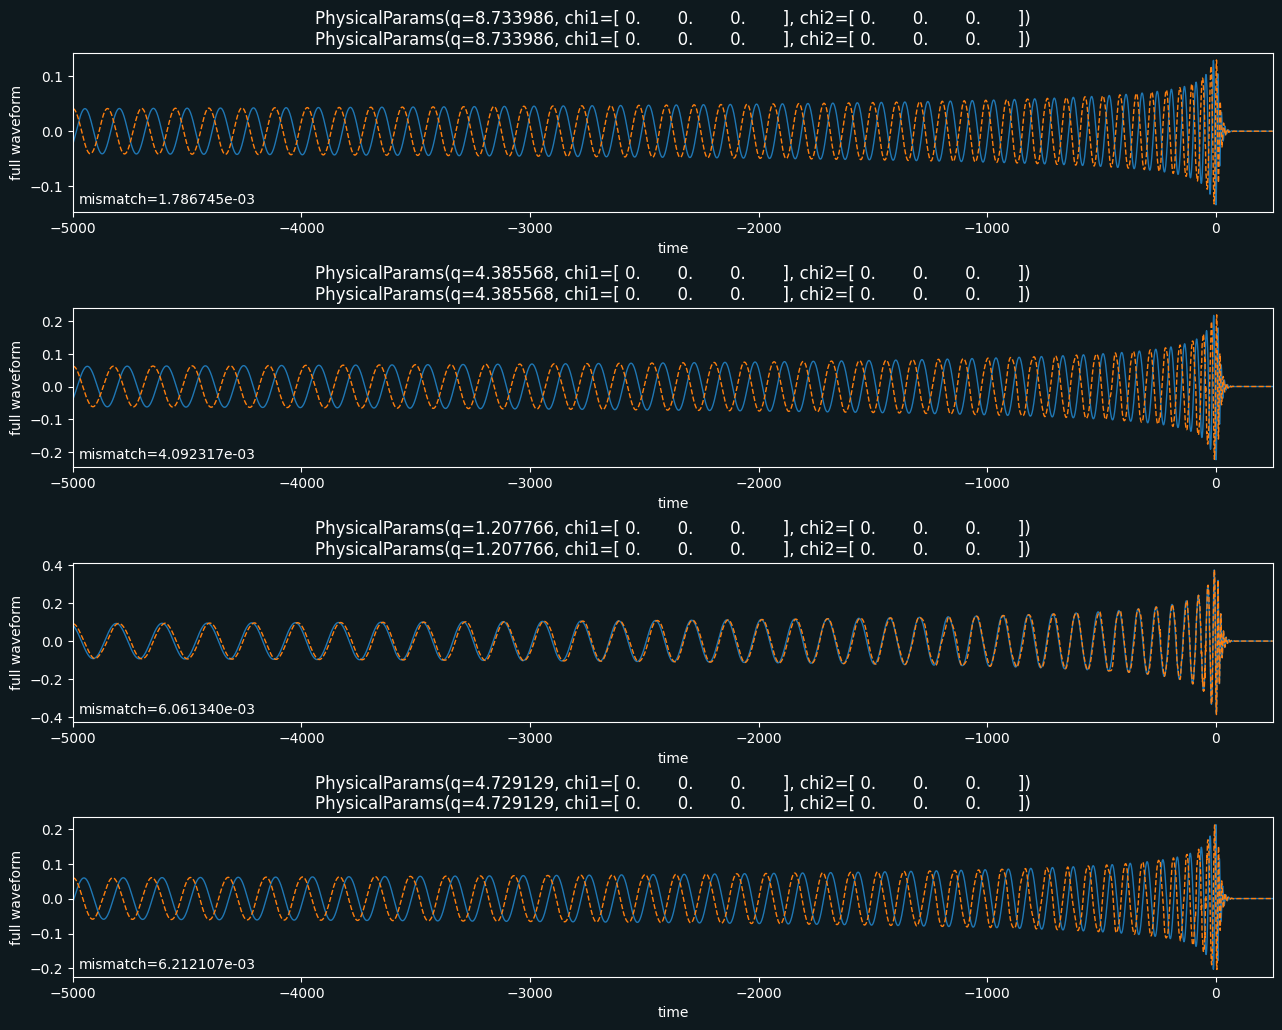

In [ ]:
# visualise_mismatch(fiducial_waveforms, romgw_waveforms, n=4, verbose=False, seed=0)

In [ ]:
plot_mismatch(
    fiducial_waveforms=,
    surrogate_waveforms=,
)